In [1]:
%matplotlib inline

import cv2
from exif import Image
from matplotlib import pyplot as plt
import numpy as np
import os
import pickle

from frameworks.opencv.homography.homography_matrix import UnmatchedKeypoints_PointFinder, UnmatchedDescriptors_Descriptor, RANSAC_MatrixEstimator, BatchHomographyMatrixEstimator
from frameworks.opencv.homography.stiching import make_stiching, color_matrix_applier, color_blender
from frameworks.pytorch.datasets.images_group_dataset import ImagesGroupDataset
from platges_utils.datasets.platgesbcn_segmentation_dataset import PlatgesBCNSegmentationDataset
from platges_utils.map_model import MapModel, gps_search_map_model, context_map_model


plt.rcParams['figure.figsize'] = [25, 15]


In [2]:

#dataset = PlatgesBCNSegmentationDataset('./data_lists/platgesbcn2021_all.csv')
dataset = ImagesGroupDataset(json_path='./data_lists/platges2022_concept.json', data_root='', downsample=None, read_flag=cv2.IMREAD_COLOR)

#print(list(dataset[0])[0][1]) # path (1) from the first image (0) of the first group (dataset[0]) unzipped

for d in list(dataset[0]):
    print(d[1])


/mnt/c/Users/Ignasi/Downloads/FOTOS_BCN_2022-04-06/panorama_stiching/imgs/DJI_0623.JPG
/mnt/c/Users/Ignasi/Downloads/FOTOS_BCN_2022-04-06/panorama_stiching/imgs/DJI_0624.JPG
/mnt/c/Users/Ignasi/Downloads/FOTOS_BCN_2022-04-06/panorama_stiching/imgs/DJI_0625.JPG
/mnt/c/Users/Ignasi/Downloads/FOTOS_BCN_2022-04-06/panorama_stiching/imgs/DJI_0626.JPG
/mnt/c/Users/Ignasi/Downloads/FOTOS_BCN_2022-04-06/panorama_stiching/imgs/DJI_0627.JPG


In [36]:

handpicked_kps = [
    cv2.KeyPoint_convert([[1487, 920], [1894, 920], [1834, 925], [1846, 931], [1893, 936]]),
    
    cv2.KeyPoint_convert([[3237, 903], [3756, 900], [3695, 905], [3705, 896], [3754, 916],
    [1374, 785], [1110, 1028], [1836, 893], [2187, 935], [916, 782], [2406, 829], [2186, 814]]),
    
    cv2.KeyPoint_convert([[3177, 762], [3530, 991], [3975, 858], [4369, 898], [2660, 761], [4450, 792], [4200, 780],
    [2386, 872], [2369, 830], [640, 866], [2885, 815]]),
    
    cv2.KeyPoint_convert([[4251, 824], [4240, 781], [2361, 831], [4673, 764],
    [1171, 931], [1693, 886], [1629, 1003], [2120, 977],
    [2735, 944], [2347, 834], [1747, 836], [220, 1054],
    [180, 979], [2704, 899], [102, 1106]]),
    
    cv2.KeyPoint_convert([[3512, 886], [3909, 845], [4272, 951], [4716, 924],
    [5248, 890], [4399, 793], [3833, 795], [2985, 1001],
    [2961, 928], [5063, 851], [3048, 1048]])
]
id_keypoints_dict = {i : kps for i, kps in enumerate(handpicked_kps)}
id_list = list(range(len(handpicked_kps)))
point_finder = UnmatchedKeypoints_PointFinder(lambda x : id_list.pop(0), id_keypoints_dict)

handpicked_descriptors = [
    [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0)],
    [(1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0)],
    [(2, 1), (2, 1), (2, 1),(2, 1), (2, 1), (2, 1), (2, 1), (2, 0), (2, 0), (2, 0), (2, 0)],
    [(3, 1), (3, 1), (3, 1), (3, 1), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0)],
    [(4, 1), (4, 1), (4, 1), (4, 1), (4, 1), (4, 1), (4, 1), (4, 1), (4, 1), (4, 1), (4, 1)]
]
id_descriptors_dict = {i : des for i, des in enumerate(handpicked_descriptors)}
id_list2 = list(range(len(handpicked_descriptors)))
descriptor_finder = UnmatchedDescriptors_Descriptor(lambda x : id_list2.pop(0), id_descriptors_dict)

def point_matcher(des1, des2):
    # desX have vectors of tuples: current_image_idx (smaller on the right size, higher on the lft size) and 0/1 (to the left correspondance == 0 and to the right correspondance == 1)
    left, right, order = (des1, des2, 1) if des1[0][0] > des2[0][0] else (des2, des1, 0)
    
    idx_left_to_right = np.argwhere(np.asarray(left)[:, 1] == 1).flatten().tolist()
    idx_right_to_left = np.argwhere(np.asarray(right)[:, 1] == 0).flatten().tolist()
    
    if order:
        return [cv2.DMatch(i, j, 10) for i, j in zip(idx_left_to_right, idx_right_to_left)]
    else:
        return [cv2.DMatch(i, j, 10) for i, j in zip(idx_right_to_left, idx_left_to_right)]

matrix_finder = RANSAC_MatrixEstimator(point_matcher=point_matcher, min_match_count=4, ransacReprojThreshold=116.1, maxIters=None)


homographies_estimator = BatchHomographyMatrixEstimator(point_finder=point_finder, descriptor_finder=descriptor_finder, matrix_finder=matrix_finder)


(7922.0, 149021.0)


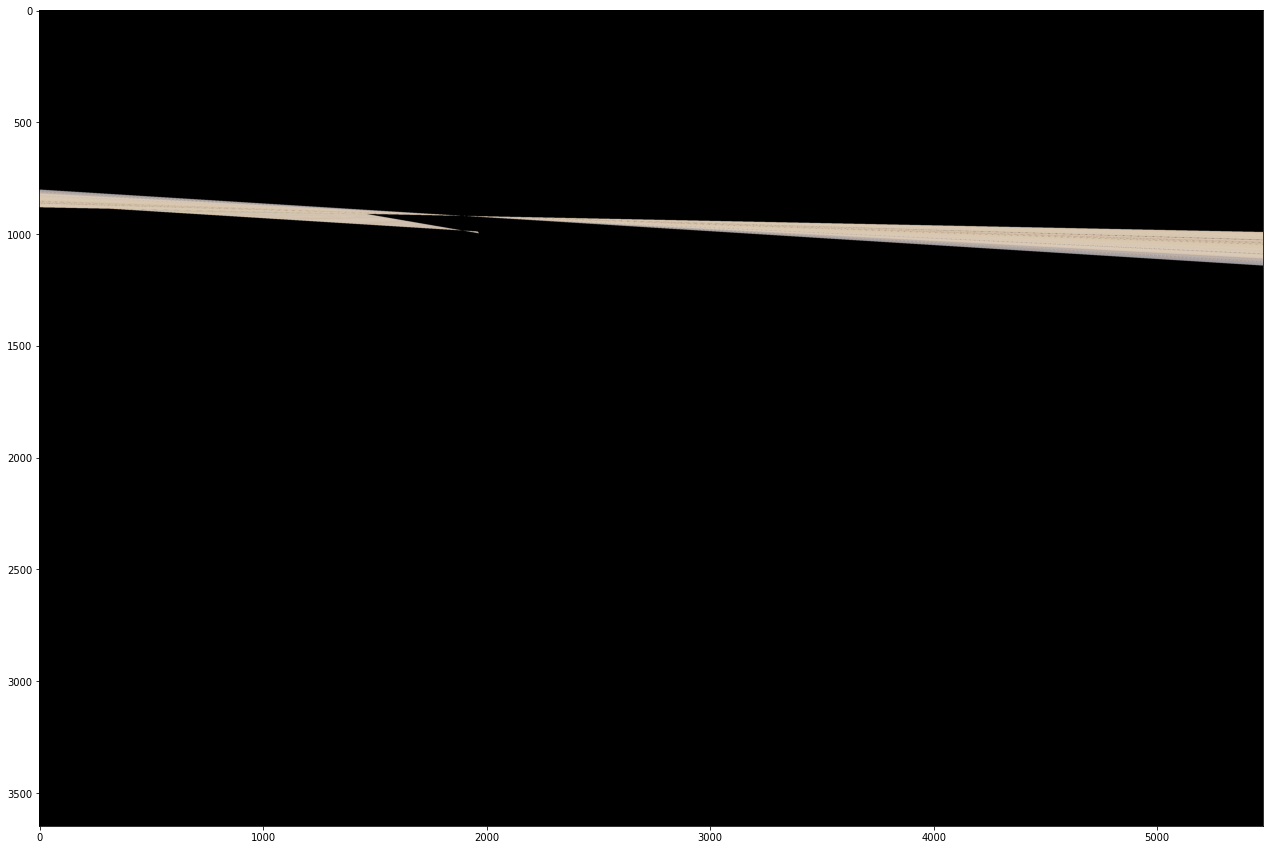

In [37]:

ann_path = '/mnt/c/Users/Ignasi/Downloads/FOTOS_BCN_2022-04-06/panorama_stiching/masks/'

v_img = []
v_masks = []
v_homographies = []
v_gps = []

for d in list(dataset[0]):
    
    v_img.append(d[0])
    
    with open(d[1], 'rb') as src:
        img = Image(src)
        gps_to_sec = lambda gps : 3600 * gps[0] + 60 * gps[1] + gps[0]
        v_gps.append((gps_to_sec(img.gps_longitude), gps_to_sec(img.gps_latitude)))
        
    with open(f'{ann_path}/{os.path.basename(d[1])[:-4]}.segments.pkl', 'rb') as f:
        mask = pickle.load(f, encoding='latin1')
        if True:
            mask[mask == 1] = 4
            mask[mask == 2] = 1
            mask[mask == 4] = 2
        v_masks.append(mask)
    
    #v_homographies.append(np.eye(3))
v_homographies, matches, inliers_mask, n_matches = homographies_estimator(v_img)

name = 'concepte'
map_model = MapModel(v_img, v_masks, v_homographies, v_gps, name)
print(map_model[0][3])
map_model.save_map_model(root='./model_parameters/mapes_platges/')

stiched = make_stiching(v_img, v_homographies, matrix_applier=color_matrix_applier, blender=color_blender)
plt.imshow(stiched)
plt.show()


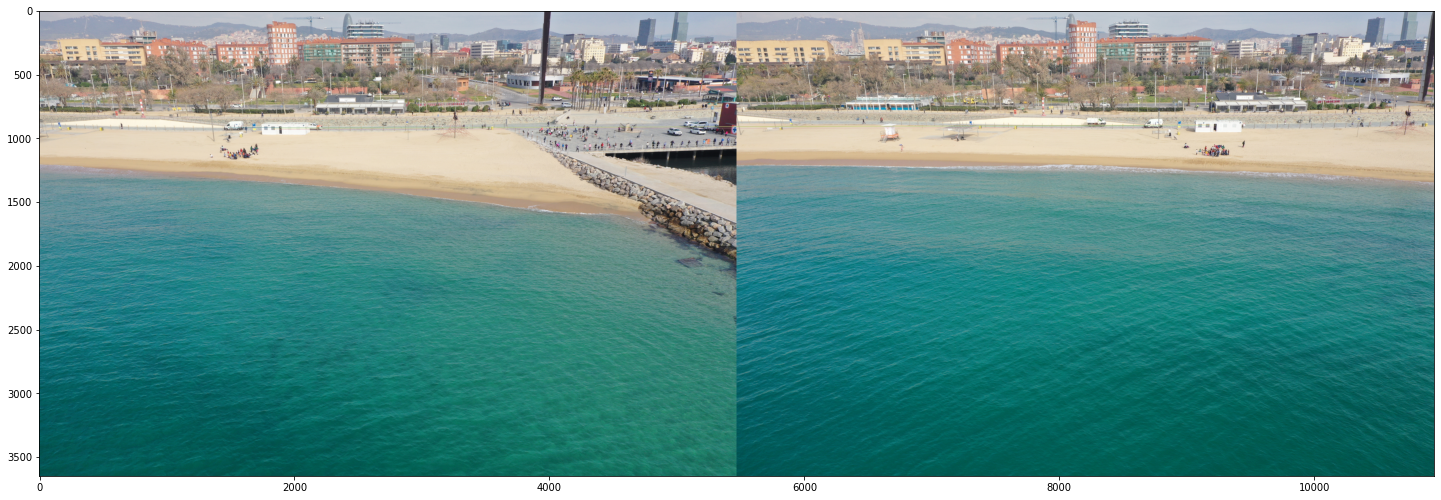

In [38]:

np.set_printoptions(formatter={'float': lambda x: f"{x:0.2f}"})

if False:
    print('---')
    for homographies in v_homographies:
        print(homographies, end='\n---\n')

if True:
    IMG1 = 2 % (len(v_img) - 1)
    IMG2 = IMG1 + 1
    output = cv2.drawMatches(v_img[0], handpicked_kps[0], v_img[1], handpicked_kps[1], matches[0, 1], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(output)
else:
    IMG = 2
    pts = cv2.KeyPoint_convert(handpicked_kps[IMG])
    plt.imshow(v_img[IMG])
    plt.plot(pts[:, 0], pts[:, 1], color='cyan', marker='o', linestyle='None', markersize=10)
plt.show()



<br>

<span style="font-size:1.25em;">
El dron te un pla de vol on les posicions de cara imatge són similars.
</span>

gps_search_map_model() aplica el criteri de menor distancia eunclidea per localitzar la platja entre els models.


In [39]:
current_filename = gps_search_map_model((7972.0, 149001.0), ['./model_parameters/mapes_platges/concepte.hdf5'])
print(current_filename)

with context_map_model(current_filename) as current_model:
    print(current_model.get_name())
    print(current_model.get_elements()[3].shape)
    

./model_parameters/mapes_platges/concepte.hdf5
concepte
(5, 2)
